RIDGE AND LASSO REGRESSION EXAMPLE

Dataset Info:
  Training samples: 160
  Test samples: 40
  Features: 10

True coefficients (sparse):
  X1: 3.00
  X4: 2.00
  X8: 1.50

1. ORDINARY LEAST SQUARES (OLS) - No Regularization

R-squared (train): 0.9800
Test MSE: 0.2817

Estimated coefficients:
  X1:  1.5865 (True:  3.00)
  X2:  0.5232 (True:  0.00)
  X3:  0.8730 (True:  0.00)
  X4:  1.9586 (True:  2.00)
  X5: -0.0015 (True:  0.00)
  X6: -0.0014 (True:  0.00)
  X7:  0.0157 (True:  0.00)
  X8:  1.5169 (True:  1.50)
  X9:  0.0005 (True:  0.00)
  X10:  0.0488 (True:  0.00)

2. RIDGE REGRESSION (L2 Regularization)

Alpha = 0.1
  Test MSE: 0.3496

Alpha = 1.0
  Test MSE: 2.0262

Alpha = 10.0
  Test MSE: 8.4903

Alpha = 100.0
  Test MSE: 11.2510

Best Ridge Alpha: 0.1 (MSE: 0.3496)
Estimated coefficients:
  X1:  0.9608 (True:  3.00)
  X2:  0.9371 (True:  0.00)
  X3:  0.9391 (True:  0.00)
  X4:  1.7733 (True:  2.00)
  X5: -0.0111 (True:  0.00)
  X6:  0.0097 (True:  0.00)
  X7:  0.0307 (True:  0.0

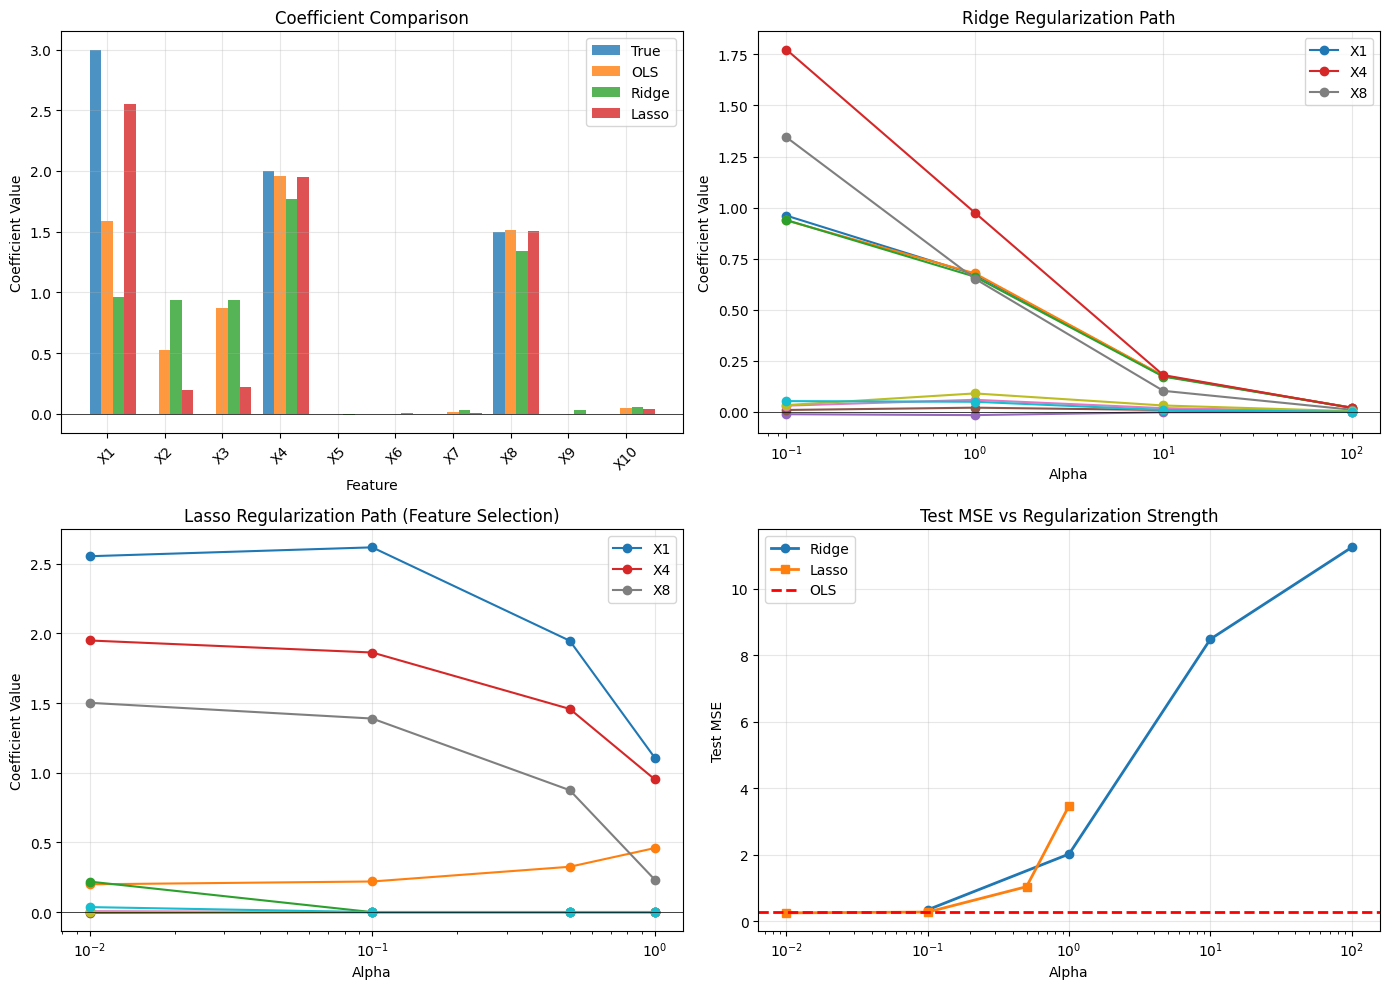


KEY INSIGHTS:
• Ridge shrinks coefficients but keeps all features
• Lasso performs feature selection by zeroing coefficients
• Both reduce overfitting compared to OLS
• Lasso correctly identified the sparse true model


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with multicollinearity
n_samples = 200
n_features = 10

# Create correlated features
X = np.random.randn(n_samples, n_features)
# Add multicollinearity by making some features correlated
X[:, 1] = X[:, 0] + np.random.randn(n_samples) * 0.1
X[:, 2] = X[:, 0] - np.random.randn(n_samples) * 0.1

# True coefficients (sparse - only a few are non-zero)
true_coef = np.array([3, 0, 0, 2, 0, 0, 0, 1.5, 0, 0])

# Generate target variable with noise
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Create DataFrame for better visualization
feature_names = [f'X{i+1}' for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_names)
df['y'] = y

# Split data into train and test sets
train_size = int(0.8 * n_samples)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Add constant term
X_train_const = add_constant(X_train)
X_test_const = add_constant(X_test)

print("=" * 70)
print("RIDGE AND LASSO REGRESSION EXAMPLE")
print("=" * 70)
print(f"\nDataset Info:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {n_features}")
print(f"\nTrue coefficients (sparse):")
for i, coef in enumerate(true_coef):
    if coef != 0:
        print(f"  {feature_names[i]}: {coef:.2f}")

# 1. ORDINARY LEAST SQUARES (OLS) - Baseline
print("\n" + "=" * 70)
print("1. ORDINARY LEAST SQUARES (OLS) - No Regularization")
print("=" * 70)

ols_model = OLS(y_train, X_train_const).fit()
print(f"\nR-squared (train): {ols_model.rsquared:.4f}")

# Predict on test set
y_pred_ols = ols_model.predict(X_test_const)
test_mse_ols = np.mean((y_test - y_pred_ols) ** 2)
print(f"Test MSE: {test_mse_ols:.4f}")

print("\nEstimated coefficients:")
for i, (name, coef) in enumerate(zip(['Intercept'] + feature_names, ols_model.params)):
    if i > 0:  # Skip intercept for comparison
        print(f"  {name}: {coef:7.4f} (True: {true_coef[i-1]:5.2f})")

# 2. RIDGE REGRESSION (L2 Regularization)
print("\n" + "=" * 70)
print("2. RIDGE REGRESSION (L2 Regularization)")
print("=" * 70)

# Try different alpha values for Ridge
alphas_ridge = [0.1, 1.0, 10.0, 100.0]
ridge_results = []

for alpha in alphas_ridge:
    ridge_model = OLS(y_train, X_train_const).fit_regularized(
        method='elastic_net',
        alpha=alpha,
        L1_wt=0  # L1_wt=0 means pure Ridge (L2)
    )
    
    # Predict on test set
    y_pred_ridge = ridge_model.predict(X_test_const)
    test_mse_ridge = np.mean((y_test - y_pred_ridge) ** 2)
    
    ridge_results.append({
        'alpha': alpha,
        'params': ridge_model.params,
        'test_mse': test_mse_ridge
    })
    
    print(f"\nAlpha = {alpha}")
    print(f"  Test MSE: {test_mse_ridge:.4f}")

# Best Ridge model
best_ridge = min(ridge_results, key=lambda x: x['test_mse'])
print(f"\nBest Ridge Alpha: {best_ridge['alpha']} (MSE: {best_ridge['test_mse']:.4f})")
print("Estimated coefficients:")
for i, (name, coef) in enumerate(zip(['Intercept'] + feature_names, best_ridge['params'])):
    if i > 0:
        print(f"  {name}: {coef:7.4f} (True: {true_coef[i-1]:5.2f})")

# 3. LASSO REGRESSION (L1 Regularization)
print("\n" + "=" * 70)
print("3. LASSO REGRESSION (L1 Regularization)")
print("=" * 70)

# Try different alpha values for Lasso
alphas_lasso = [0.01, 0.1, 0.5, 1.0]
lasso_results = []

for alpha in alphas_lasso:
    lasso_model = OLS(y_train, X_train_const).fit_regularized(
        method='elastic_net',
        alpha=alpha,
        L1_wt=1  # L1_wt=1 means pure Lasso (L1)
    )
    
    # Predict on test set
    y_pred_lasso = lasso_model.predict(X_test_const)
    test_mse_lasso = np.mean((y_test - y_pred_lasso) ** 2)
    
    # Count non-zero coefficients (excluding intercept)
    n_nonzero = np.sum(np.abs(lasso_model.params[1:]) > 1e-5)
    
    lasso_results.append({
        'alpha': alpha,
        'params': lasso_model.params,
        'test_mse': test_mse_lasso,
        'n_nonzero': n_nonzero
    })
    
    print(f"\nAlpha = {alpha}")
    print(f"  Test MSE: {test_mse_lasso:.4f}")
    print(f"  Non-zero coefficients: {n_nonzero}/{n_features}")

# Best Lasso model
best_lasso = min(lasso_results, key=lambda x: x['test_mse'])
print(f"\nBest Lasso Alpha: {best_lasso['alpha']} (MSE: {best_lasso['test_mse']:.4f})")
print("Estimated coefficients:")
for i, (name, coef) in enumerate(zip(['Intercept'] + feature_names, best_lasso['params'])):
    if i > 0:
        if abs(coef) > 1e-5:
            print(f"  {name}: {coef:7.4f} (True: {true_coef[i-1]:5.2f}) *")
        else:
            print(f"  {name}: {coef:7.4f} (True: {true_coef[i-1]:5.2f}) [zeroed]")

# 4. COMPARISON VISUALIZATION
print("\n" + "=" * 70)
print("4. MODEL COMPARISON")
print("=" * 70)
print(f"\nTest MSE Comparison:")
print(f"  OLS:          {test_mse_ols:.4f}")
print(f"  Ridge (best): {best_ridge['test_mse']:.4f}")
print(f"  Lasso (best): {best_lasso['test_mse']:.4f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Coefficient comparison
ax1 = axes[0, 0]
x_pos = np.arange(n_features)
width = 0.2
ax1.bar(x_pos - width, true_coef, width, label='True', alpha=0.8)
ax1.bar(x_pos, ols_model.params[1:], width, label='OLS', alpha=0.8)
ax1.bar(x_pos + width, best_ridge['params'][1:], width, label='Ridge', alpha=0.8)
ax1.bar(x_pos + 2*width, best_lasso['params'][1:], width, label='Lasso', alpha=0.8)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Coefficient Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(feature_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Plot 2: Ridge regularization path
ax2 = axes[0, 1]
ridge_coefs = np.array([r['params'][1:] for r in ridge_results]).T
for i, coef_path in enumerate(ridge_coefs):
    ax2.plot([r['alpha'] for r in ridge_results], coef_path, 
             marker='o', label=feature_names[i] if true_coef[i] != 0 else None)
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Ridge Regularization Path')
ax2.set_xscale('log')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Plot 3: Lasso regularization path
ax3 = axes[1, 0]
lasso_coefs = np.array([r['params'][1:] for r in lasso_results]).T
for i, coef_path in enumerate(lasso_coefs):
    ax3.plot([r['alpha'] for r in lasso_results], coef_path,
             marker='o', label=feature_names[i] if true_coef[i] != 0 else None)
ax3.set_xlabel('Alpha')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Lasso Regularization Path (Feature Selection)')
ax3.set_xscale('log')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Plot 4: Test MSE comparison
ax4 = axes[1, 1]
ridge_mses = [r['test_mse'] for r in ridge_results]
lasso_mses = [r['test_mse'] for r in lasso_results]
ax4.plot([r['alpha'] for r in ridge_results], ridge_mses, 
         marker='o', label='Ridge', linewidth=2)
ax4.plot([r['alpha'] for r in lasso_results], lasso_mses,
         marker='s', label='Lasso', linewidth=2)
ax4.axhline(y=test_mse_ols, color='red', linestyle='--', 
            label='OLS', linewidth=2)
ax4.set_xlabel('Alpha')
ax4.set_ylabel('Test MSE')
ax4.set_title('Test MSE vs Regularization Strength')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ridge_lasso_comparison.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'ridge_lasso_comparison.png'")
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
print("• Ridge shrinks coefficients but keeps all features")
print("• Lasso performs feature selection by zeroing coefficients")
print("• Both reduce overfitting compared to OLS")
print("• Lasso correctly identified the sparse true model")
print("=" * 70)